In [1]:
!mkdir -p /root/.config/kaggle/
!cp /content/drive/MyDrive/kaggle.json /root/.config/kaggle/kaggle.json
!chmod 600 /root/.config/kaggle/kaggle.json

In [2]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('aslanahmedov/number-plate-detection', path="/content/number-plate-detection", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/aslanahmedov/number-plate-detection


In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.patches as patches

In [4]:
# Set path to your dataset
path = '/content/number-plate-detection/images/'

In [5]:
# Function to parse XML files and create a DataFrame
def create_dataframe(path):
    labels_dict = dict(filepath=[], xmin=[], xmax=[], ymin=[], ymax=[])

    for file in sorted(os.listdir(path)):
        if file.endswith('.xml'):
            info = xet.parse(os.path.join(path, file))
            root = info.getroot()
            obj = root.find('object')
            l_info = obj.find('bndbox')
            xmin = int(l_info.find('xmin').text)
            xmax = int(l_info.find('xmax').text)
            ymin = int(l_info.find('ymin').text)
            ymax = int(l_info.find('ymax').text)

            labels_dict['filepath'].append(os.path.join(path, file[:-3] + 'jpeg'))
            labels_dict['xmin'].append(xmin)
            labels_dict['xmax'].append(xmax)
            labels_dict['ymin'].append(ymin)
            labels_dict['ymax'].append(ymax)

    return pd.DataFrame(labels_dict)

In [6]:
# Create DataFrame
df = create_dataframe(path)

In [41]:
# EDA: Display sample images from the dataset with bounding boxes
def display_sample_images_with_boxes(df, num_samples=5, seed=40):
    np.random.seed(seed)
    sample_indices = np.random.choice(len(df), num_samples, replace=False)

    fig, axs = plt.subplots(1, num_samples, figsize=(20, 4))
    for i, idx in enumerate(sample_indices):
        # Read the image
        img = cv2.imread(df.iloc[idx]['filepath'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get bounding box coordinates
        xmin, xmax, ymin, ymax = df.iloc[idx][['xmin', 'xmax', 'ymin', 'ymax']]

        # Display the image
        axs[i].imshow(img)

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')

        # Add the rectangle to the image
        axs[i].add_patch(rect)

        axs[i].axis('off')
        axs[i].set_title(f"Sample {i+1}")

    plt.tight_layout()
    plt.show()

    return sample_indices

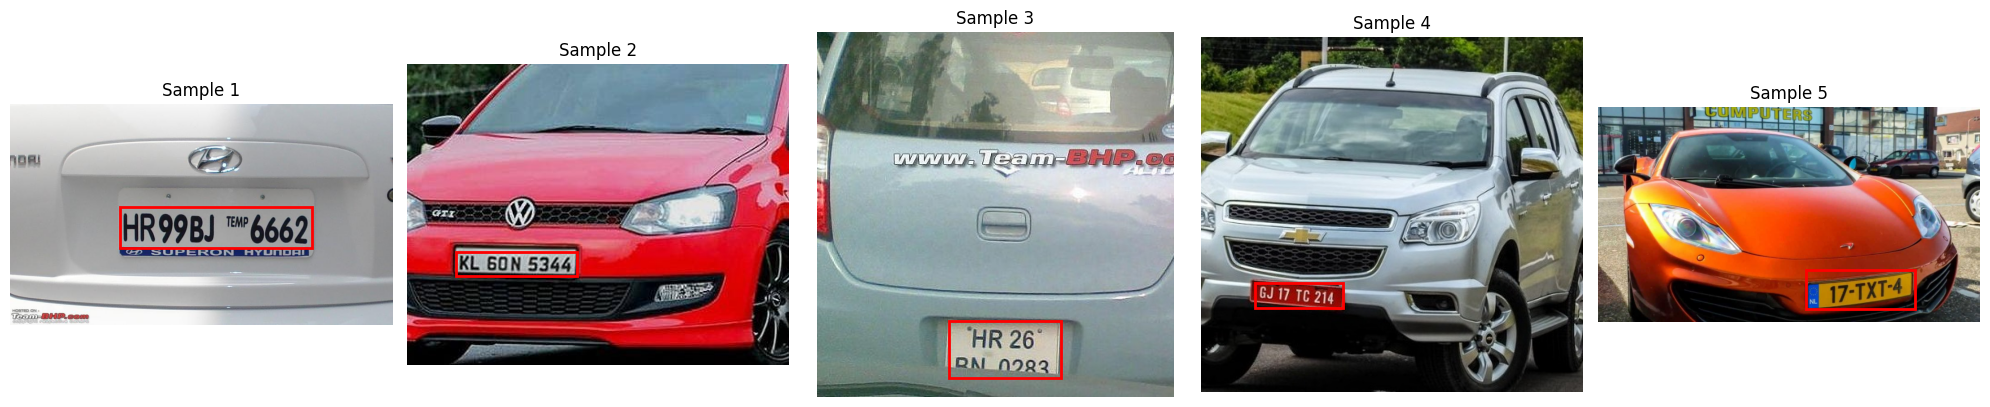

In [42]:
# Call the function to display sample images with bounding boxes
sample_indices = display_sample_images_with_boxes(df, num_samples=5, seed=40)

In [11]:
# Prepare data for model
data = []
output = []
image_sizes = []

for i in range(len(df)):
    image = df.iloc[i]['filepath']
    img_arr = cv2.imread(image)
    h, w, _ = img_arr.shape
    image_sizes.append((h, w))

    load_image = load_img(image, target_size=(224, 224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr / 255.0

    xmin, xmax, ymin, ymax = df.iloc[i][['xmin', 'xmax', 'ymin', 'ymax']]
    nxmin, nxmax = xmin / w, xmax / w
    nymin, nymax = ymin / h, ymax / h
    label_norm = (nxmin, nxmax, nymin, nymax)

    data.append(norm_load_image_arr)
    output.append(label_norm)

X = np.array(data, dtype=np.float32)
y = np.array(output, dtype=np.float32)
image_sizes = np.array(image_sizes)

In [12]:
# Split data into train and test sets
X_train, X_test, y_train, y_test, sizes_train, sizes_test = train_test_split(
    X, y, image_sizes, test_size=0.2, random_state=42
)

In [13]:
# Create model
def create_model():
    inception_resnet = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    x = inception_resnet.output
    x = Flatten()(x)
    x = Dense(600, activation=tf.keras.layers.LeakyReLU(alpha=0.01))(x)
    x = Dense(300, activation=tf.keras.layers.LeakyReLU(alpha=0.01))(x)
    output = Dense(4, activation='sigmoid')(x)
    model = Model(inputs=inception_resnet.input, outputs=output)
    return model

model = create_model()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [14]:
# Compile model
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 77,558,840 (295.86 MB)

 Trainable params: 77,498,296 (295.63 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [15]:
# Define callback
model_checkpoint = ModelCheckpoint('best_model.weights.h5', save_best_only=True, save_weights_only=True)

In [16]:
# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[model_checkpoint]
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 244s 17s/step - loss: 0.1021 - mae: 0.2694 - val_loss: 0.1385 - val_mae: 0.3276
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.1054 - mae: 0.2722 - val_loss: 0.1137 - val_mae: 0.3066
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 758ms/step - loss: 0.0869 - mae: 0.2409 - val_loss: 0.0993 - val_mae: 0.2732
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 729ms/step - loss: 0.0772 - mae: 0.2151 - val_loss: 0.0752 - val_mae: 0.2203
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 749ms/step - loss: 0.0544 - mae: 0.1685 - val_loss: 0.0542 - val_mae: 0.1803
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 742ms/step - loss: 0.0382 - mae: 0.1367 - val_loss: 0.0261 - val_mae: 0.1254
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 753ms/step - loss: 0.0266 - mae: 0.1127 - val_loss: 0.0173 - val_mae: 0.1024
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 717ms/step - loss: 0.0113 - mae: 0.0791 - val_loss: 0.0170 - val_mae: 0.1020
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 749ms/step - loss: 0.0074 -

In [17]:
# Load best weights and save model
model.load_weights('best_model.weights.h5')
model.save('/content/drive/MyDrive/ML/Number-Plate-Recognition/Number-Plate-Recognition.keras')

print("Model saved as 'Number-Plate-Recognition.keras'")

Model saved as 'Number-Plate-Recognition.keras'


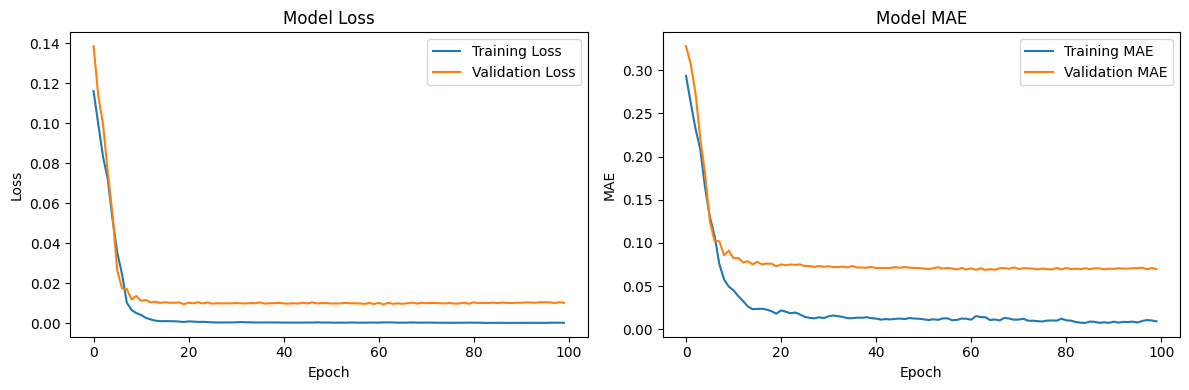

In [18]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [19]:
# Evaluate model
y_pred = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 10s/step


In [39]:
def compare_original_and_predicted_boxes(df, model, sample_indices):
    fig, axs = plt.subplots(1, len(sample_indices), figsize=(20, 4))

    for i, idx in enumerate(sample_indices):
        # Get the filepath for the current sample
        filepath = df.iloc[idx]['filepath']

        # Read the original image
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get original image size
        h, w, _ = img.shape

        # Preprocess the image for the model
        img_resized = load_img(filepath, target_size=(224, 224))
        img_array = img_to_array(img_resized)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0  # Normalize

        # Predict using the model
        predicted_box_norm = model.predict(img_array)[0]

        # Get original (non-normalized) bounding box
        original_box = df.iloc[idx][['xmin', 'xmax', 'ymin', 'ymax']].values

        # Denormalize predicted bounding box
        predicted_box = predicted_box_norm * [w, w, h, h]

        # Display the image
        axs[i].imshow(img)

        # Create Rectangle patches
        original_rect = patches.Rectangle((original_box[0], original_box[2]),
                                          original_box[1] - original_box[0],
                                          original_box[3] - original_box[2],
                                          linewidth=2, edgecolor='r', facecolor='none')

        predicted_rect = patches.Rectangle((predicted_box[0], predicted_box[2]),
                                           predicted_box[1] - predicted_box[0],
                                           predicted_box[3] - predicted_box[2],
                                           linewidth=2, edgecolor='g', facecolor='none')

        # Add the rectangles to the image
        axs[i].add_patch(original_rect)
        axs[i].add_patch(predicted_rect)

        axs[i].axis('off')
        axs[i].set_title(f"Sample {i+1}")

    # Add a legend
    fig.legend([original_rect, predicted_rect], ['Original', 'Predicted'], loc='lower center', ncol=2)

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


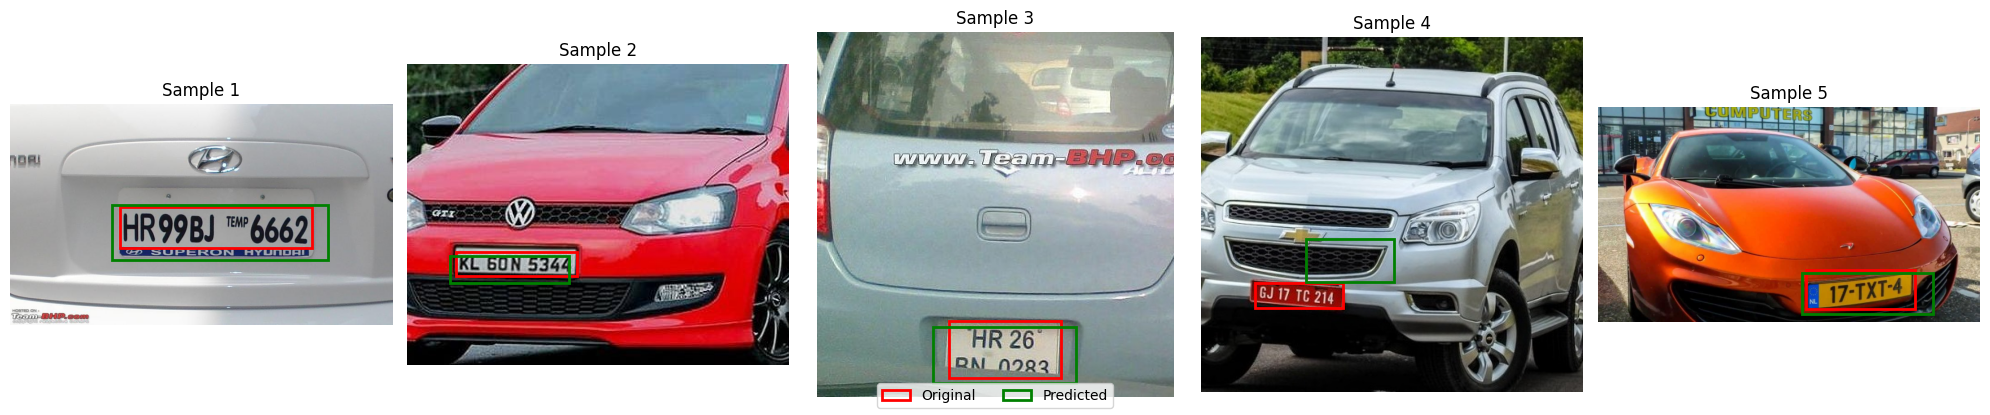

In [43]:
# Compare original and predicted bounding boxes
compare_original_and_predicted_boxes(df, model, sample_indices)